# Notebook for `dockerHDDM`

Author: Hu Chuan-Peng (PhD) @Nanjing Normal University
E-mail: hcp4715@hotmail.com


This is a supplementary notebook for the introductary paper *A Hitchhiker’s Guide to Bayesian Hierarchical Drift-Diffusion Modeling with dockerHDDM*. 

In this notebook, we will demostrate how to conduct HDDM analysis with docker image [`hcp4715/hddm:0.8_tutorial`](https://hub.docker.com/r/hcp4715/hddm/tags).

Preprint of this manuscript:

## Before start

This notebook should be work with hcp4715/hddm:0.8_tutorial, which include HDDM 0.8.0 and its dependcies, e.g., `pymc2.3.8`, `kabuki 0.6.4`. In that docker image, we also included `arviz` (which depends on `xarray`), `searborn`, and `p_tqdm`. 

In addition, in-house scripts used in this notebook contain several new functions, which was placed in the `scripts` folder. 

If you are not using the docker image, you may download these scripts and add them to your working directory.

We encourage you to install docker and pull docker image.

## Loading modules/packages

In [1]:
%matplotlib inline

# General packages for system, time, etc
import os, time, csv, sys
import datetime
from datetime import date
import glob

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current kabuki version is: ", kabuki.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

# parallel processing related
from p_tqdm import p_map
from functools import partial

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


The current HDDM version is:  0.8.0
The current kabuki version is:  0.6.4
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.12.0


###  Import new functions

These scripts are stored at the `scripts` folder, which need to be added to the path.

In [2]:
# add `script` to the python path so that we can import the scripts
# scripts_dir = '/home/jovyan/work/scripts'
scripts_dir = '/home/jovyan/scripts'
sys.path.append(scripts_dir)

from HDDMarviz import HDDMarviz
from InferenceDataFromHDDM import InferenceDataFromHDDM
from plot_ppc_by_cond import plot_ppc_by_cond

#### Load the example data Cavanaght et al. (2011)

The data file is included in HDDM, so we directly load it.

In [3]:
data_cavanagh = hddm.load_csv(hddm.__path__[0] + '/examples/cavanagh_theta_nn.csv')
data_cavanagh.tail()

subj_idx stim     rt  response     theta  dbs conf
3983        13   LL  1.450       0.0 -1.237166    0   HC
3984        13   WL  0.711       1.0 -0.377450    0   LC
3985        13   WL  0.784       1.0 -0.694194    0   LC
3986        13   LL  2.350       0.0 -0.546536    0   HC
3987        13   WW  1.250       1.0  0.752388    0   HC

In [4]:
data_cavanagh.shape

(3988, 7)

## Fit a single model

To fit a single model, we need first to define a model using a python function, then sample from the posterior distribution and get the posterior traces for each parameter.

### Defining a model
**As in `code block 1` in the tutorial**, we can define a model and fit this model with multiple chains. The code below is the code in `code block 1` in the tutorial. This definition of `ms4` will return a model defining object in python.

In [5]:
def ms4(id, df=None, samples=None, burn=None, thin=1, save_name="ms4"): 
    """
    This function defines a function that run a HDDM model
    id — the id of a cpu thread
    data — The input data
    samples — number of samples for MCMC
    burn — number of burn in (or warm-up) of MCMC
    thin — number of thin, the same as in HDDM
    save_name — prefix of file name when saving the model objects.
    """
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDMRegressor(df,
                           "v ~ C(conf, Treatment('LC'))", 
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m


### Fit the model with four chains
**As in `code block 2` in the tutorial**, we will now run four chains for `ms4`. 

There are several differences between the code block below and `code block 2` in the tutorial: 

* We used `%%time` at the beginning of this code block to record the time cost for this model.
* As `p_tqdm` and `functools` were already imported at the beginning of the notebook, we do not need to import them again.
* We tried to search for files whose name contains `ms4_tmp_chain_` in the current working directory. If we found these files, it means that we already fitted the model before and saved the model results object into the current working directory. This is possible because `ms4_tmp` was assigned to the argument `save_name`, which is quite unususal string. If we found these files, we will load these files instead of re-fitting the model, otherwise, we will fit the model using `p_map()`. 

In [6]:
%%time

chains = 4

file_names = glob.glob("ms4_tmp" + "_chain_*[!db]", recursive=False)

if file_names:
    file_names = sorted(file_names, key=lambda x: x[-1]) # sort filenames by chain ID
    ms4res = []
    for fname in file_names:
        print('current loading: ', fname, '\n')
        ms4res.append(hddm.load(fname))
else:
    ms4res = p_map(partial(ms4, df=data_cavanagh, samples=2000, burn=500, save_name="ms4_tmp"), range(chains))

current loading:  ms4_tmp_chain_0 

current loading:  ms4_tmp_chain_1 

current loading:  ms4_tmp_chain_2 

current loading:  ms4_tmp_chain_3 

CPU times: user 10.6 s, sys: 274 ms, total: 10.9 s
Wall time: 11.2 s


We can check the model results object `ms2res`, which is a list of four elements, each is a chain of the `ms2`.

In [7]:
ms4res

### Convert HDDM model result objects to InferenceData

Then we can use `InferenceDataFromHDDM` to convert the HDDM model results to InferenceData. Note that `InferenceDataFromHDDM` will also search saved InferenceData files, in `netcdf` format, using the input of save_name in the current working direct. 

**The code block below is presented in the tutorial as `code block 3`.**

In [8]:
%%time
InfData_ms4 = InferenceDataFromHDDM(ms4res, nppc = 300, save_name="ms4_tmp")

Inference data  ms4_tmp  already exist, will load model data instead of re-run
CPU times: user 144 ms, sys: 12 ms, total: 156 ms
Wall time: 188 ms


### From model definition object to InferenceData

**As in `code block 4` in the tutorial**, we can combine model fitting and InferenceData converting into a single step.

In [9]:
ms4res, InfData_ms4 = HDDMarviz(data = data_cavanagh,             # data to be used
                                 model_func=ms4,                  # model function(s) 
                                 samples=2000,                    # samples for MCMC 
                                 burn=1000,                       # burn in (or warmup)
                                 thin=1,                          # thin as in HDDM 
                                 chains=4,                        # chains  
                                 nppc=500,                        # as in InferenceDataFromHDDM
                                 savetag="tmp")                   # additional tag when saving files

Inference data  ms4_tmp  already exist, will load model data instead of re-run
current loading:  ms4_tmp_chain_0 

current loading:  ms4_tmp_chain_1 

current loading:  ms4_tmp_chain_2 

current loading:  ms4_tmp_chain_3 



### Exploring the model with `ArviZ`

#### Plot the trace of the model

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'a_std'}>,
        <AxesSubplot:title={'center':'a_std'}>],
       [<AxesSubplot:title={'center':'a_subj.0'}>,
        <AxesSubplot:title={'center':'a_subj.0'}>],
       [<AxesSubplot:title={'center':'a_subj.1'}>,
        <AxesSubplot:title={'center':'a_subj.1'}>],
       [<AxesSubplot:title={'center':'a_subj.2'}>,
        <AxesSubplot:title={'center':'a_subj.2'}>],
       [<AxesSubplot:title={'center':'a_subj.3'}>,
        <AxesSubplot:title={'center':'a_subj.3'}>],
       [<AxesSubplot:title={'center':'a_subj.4'}>,
        <AxesSubplot:title={'center':'a_subj.4'}>],
       [<AxesSubplot:title={'center':'a_subj.5'}>,
        <AxesSubplot:title={'center':'a_subj.5'}>],
       [<AxesSubplot:title={'center':'a_subj.6'}>,
        <AxesSubplot:title={'center':'a_subj.6'}>],
       [<AxesSubplot:title={'center':'a_subj.7'}>,
        <AxesSubplot:title={'center':'a_su

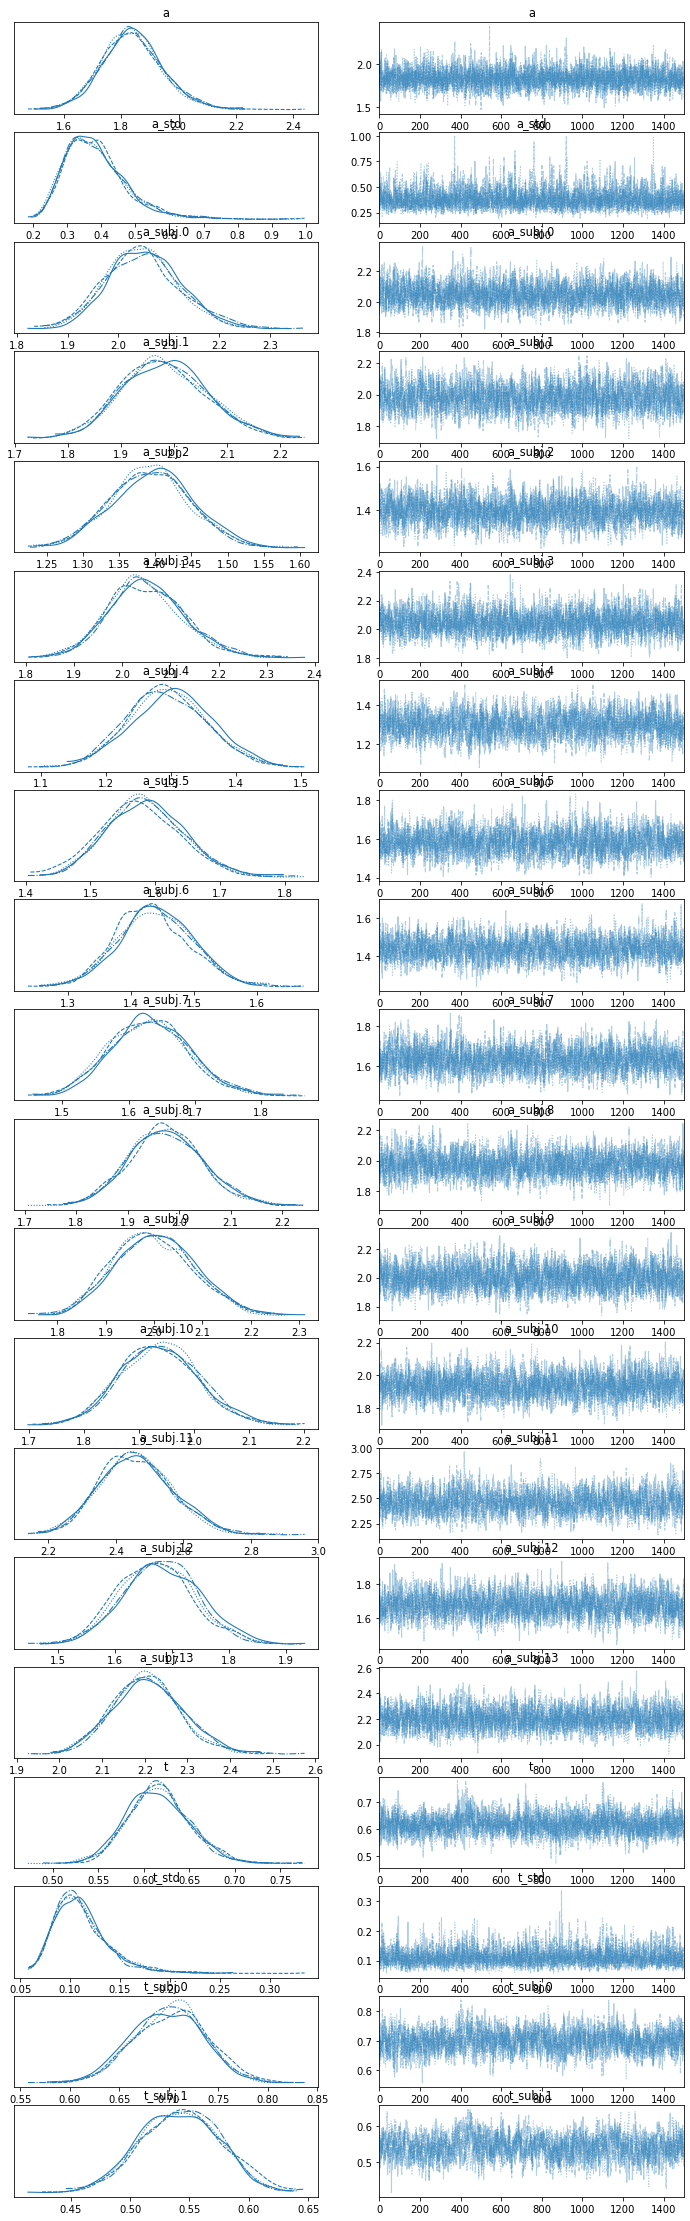

In [10]:
az.plot_trace(InfData_ms4)

array([[<AxesSubplot:title={'center':'t'}>,
        <AxesSubplot:title={'center':'t'}>]], dtype=object)

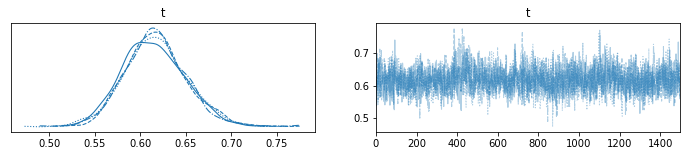

In [11]:
az.plot_trace(InfData_ms4, var_names=("^t(?!.*(subj|std))"), filter_vars='regex')

Combine chains to one.

array([[<AxesSubplot:title={'center':'v_Intercept'}>,
        <AxesSubplot:title={'center':'v_Intercept'}>],
       [<AxesSubplot:title={'center':"v_C(conf, Treatment('LC'))[T.HC]"}>,
        <AxesSubplot:title={'center':"v_C(conf, Treatment('LC'))[T.HC]"}>]],
      dtype=object)

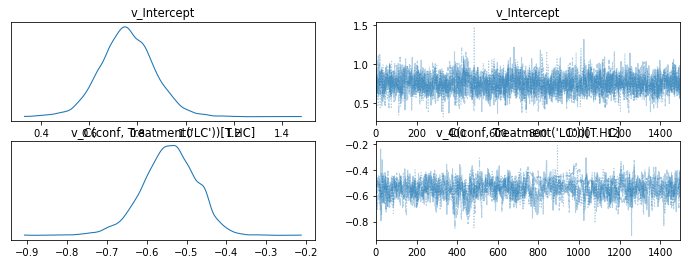

In [12]:
az.plot_trace(InfData_ms4, var_names=("^v(?!.*(subj|std))"), filter_vars='regex', combined=True) 

#### Model diagnosis
Using `az.summary()` to check $\hat{R}$ and Effective Sample Size (ESS)

In [13]:
ms4_summary_tmp = az.summary(InfData_ms4, round_to=4)
ms4_summary_tmp.sort_values('r_hat')

mean      sd  hdi_3%  hdi_97%  \
a_subj.8                                 1.9744  0.0721  1.8373   2.1091   
a_std                                    0.3838  0.0913  0.2389   0.5540   
t_std                                    0.1113  0.0275  0.0644   0.1613   
a                                        1.8385  0.1060  1.6303   2.0349   
a_subj.6                                 1.4380  0.0582  1.3357   1.5518   
...                                         ...     ...     ...      ...   
v_C(conf, Treatment('LC'))[T.HC]        -0.5435  0.0676 -0.6667  -0.4172   
v_C(conf, Treatment('LC'))[T.HC]_subj.5 -0.6452  0.1269 -0.8782  -0.4280   
v_C(conf, Treatment('LC'))[T.HC]_std     0.1437  0.0739  0.0011   0.2620   
z_trans                                  0.0433  0.0366 -0.0217   0.1128   
z_std                                    0.0426  0.0304  0.0002   0.0974   

                                         mcse_mean  mcse_sd   ess_bulk  \
a_subj.8                                    0.0018   0.0012  1701.5407   
a_std                                       0.0019   0.0014  2636.2255   
t_std                                       0.0006   0.0004  2699.6516   
a                                           0.0021   0.0015  2551.4512   
a_subj.6                                    0.0016   0.0011  1346.8766   
...                                            ...      ...        ...   
v_C(conf, Treatment('LC'))[T.HC]            0.0059   0.0042   113.3890   
v_C(conf, Treatment('LC'))[T.HC]_subj.5     0.0114   0.0081   103.5680   
v_C(conf, Treatment('LC'))[T.HC]_std        0.0068   0.0048    91.3184   
z_trans                                     0.0029   0.0021   161.5203   
z_std                                       0.0029   0.0020    70.4071   

                                          ess_tail   r_hat  
a_subj.8                                 2598.7518  1.0009  
a_std                                    2849.6249  1.0010  
t_std                                    2992.3746  1.0013  
a                                        2954.3523  1.0017  
a_subj.6                                 2520.7726  1.0020  
...                                            ...     ...  
v_C(conf, Treatment('LC'))[T.HC]          592.4010  1.0326  
v_C(conf, Treatment('LC'))[T.HC]_subj.5   117.9329  1.0328  
v_C(conf, Treatment('LC'))[T.HC]_std       22.1506  1.0335  
z_trans                                   529.0049  1.0383  
z_std                                      54.2854  1.0501  

[83 rows x 9 columns]

#### Plot the posterior predictives

array([<AxesSubplot:xlabel='rt / rt'>,
       <AxesSubplot:xlabel='response / response'>], dtype=object)

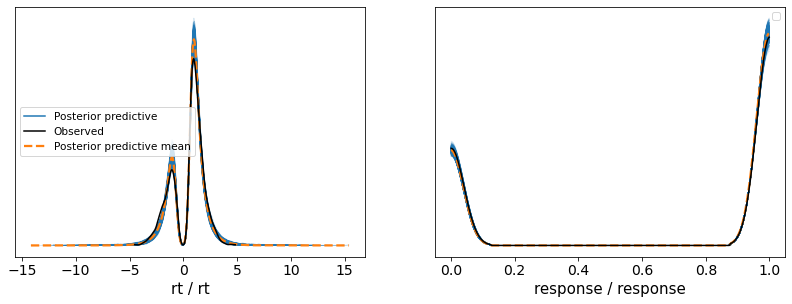

In [14]:
az.plot_ppc(InfData_ms4)

#### Check `loo` and `waic`

In [15]:
az.loo(InfData_ms4, scale="deviance")

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Computed from 6000 by 3988 log-likelihood matrix

             Estimate       SE
deviance_loo 14139.97  1550.18
p_loo         1665.25        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3972   99.6%
 (0.5, 0.7]   (ok)          2    0.1%
   (0.7, 1]   (bad)         4    0.1%
   (1, Inf)   (very bad)   10    0.3%

In [16]:
az.waic(InfData_ms4, scale="deviance")

Computed from 6000 by 3988 log-likelihood matrix

              Estimate       SE
deviance_waic 23664.22  6818.23
p_waic         6427.38        -

There has been a warning during the calculation. Please check the results.

#### Plot posterior of multiple parameters

array([<AxesSubplot:title={'center':'v_Intercept'}>,
       <AxesSubplot:title={'center':"v_C(conf, Treatment('LC'))[T.HC]"}>],
      dtype=object)

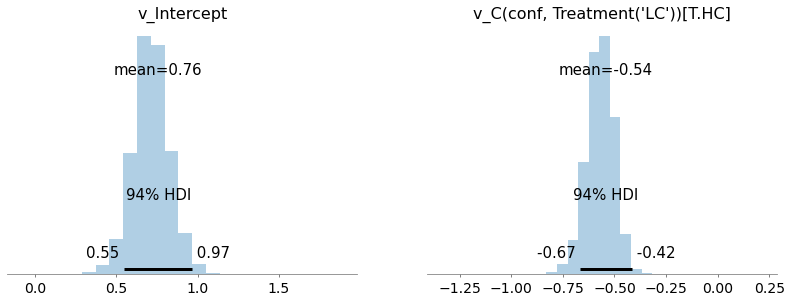

In [17]:
az.plot_posterior(InfData_ms4, var_names=("^v(?!.*(subj|std))"), filter_vars='regex', 
                  kind='hist')

Compare posterior using plot_forest. See [`az.plot_forest`](https://python.arviz.org/en/latest/api/generated/arviz.plot_forest.html#arviz.plot_forest) for more.

array([<AxesSubplot:>], dtype=object)

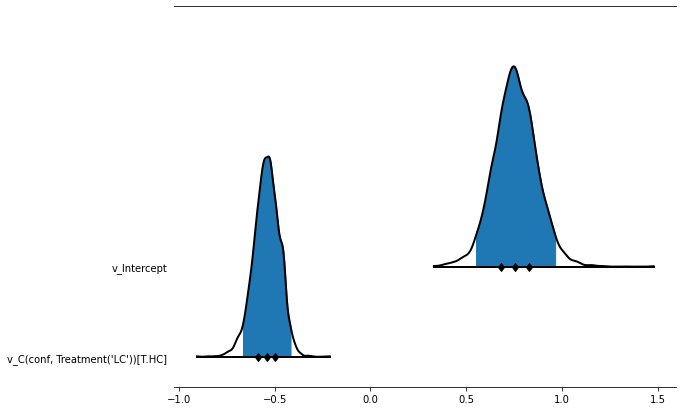

In [18]:
 az.plot_forest(InfData_ms4,
                kind='ridgeplot',
                var_names=("^v(?!.*(subj|std))"), 
                filter_vars="regex", 
                linewidth=2,
                ridgeplot_overlap=3,
                ridgeplot_truncate=False,
                ridgeplot_quantiles=[.25, .5, .75],
                combined=True,
                figsize=(9, 7))

Similarly, violin plot can also be used:

array([<AxesSubplot:title={'center':'v_Intercept'}>,
       <AxesSubplot:title={'center':"v_C(conf, Treatment('LC'))[T.HC]"}>],
      dtype=object)

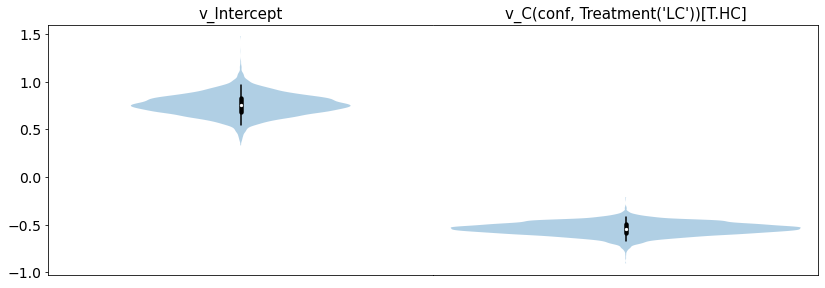

In [19]:
az.plot_violin(InfData_ms4, var_names=("^v(?!.*(subj|std))"), filter_vars='regex')
#               side="left", show=False)

## Fitting multiple models

Here we will fit the data with five models that has mentioned in the tutorial 

### Define model functions for parallel processing

Here we defined five models, from the simplest DDM to full DDM to regression models. Explanation for these five models can be found in **Section "Data and Example Models"** in the primer.

In [20]:
%%time

# M0_0: base model: simplified
def ms0(id, df=None, samples=None, burn=None, thin=1, save_name="ms0"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df)
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

# M1: base model: full model
def ms1(id, df=None, samples=None, burn=None, thin=1, save_name="ms1"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df, include=['z', 'sv', 'sz', 'st'])
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

# M2: treat within-subj as between-subj: full model
def ms2(id, df=None, samples=None, burn=None, thin=1, save_name="ms2"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id      
    m = hddm.HDDM(df, include=['z', 'sv', 'st', 'sz'], 
                  depends_on={'v': 'conf'})
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m


# M3: regression model (varying intercept)
def ms3(id, df=None, samples=None, burn=None, thin=1, save_name="ms3"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id      
    m = hddm.HDDMRegressor(df,  
                           "v ~ C(conf, Treatment('LC'))", 
                           group_only_regressors=True,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

# M4: regression model (varying intercept and slope)
def ms4(id, df=None, samples=None, burn=None, thin = 1, save_name="ms4"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDMRegressor(df,
                           "v ~ C(conf, Treatment('LC'))", 
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 13.1 µs


Here, we have a `test_mode` to quickly test the code. If `test_mode` is true, then the samples, burn, number of posterior predictives (nppc) will be relatively small.

In [21]:
test_mode = False

if test_mode:
    samples = 800      # number of MCMC sample; Cavanagh et al.2011 used 30,000
    burn = 300         # number of burn in; Cavanagh et al.2011 used 10,000
    nppc = 200         # number of posterior predictive, super slow
    thin = 1           # thining
    chains = 4         # number of chains, default is 4
    savefile=False     # save file or not, only "True" is available for now.
    savetag = "tmp"    # tag added to saved files.
    model_func = [ms0,
                  ms4] # only test two simple models
else:
    samples = 40000    # number of MCMC sample; Cavanagh et al.2011 used 30,000
    burn = 10000       # number of burn in; Cavanagh et al.2011 used 10,000
    nppc = 5000        # number of posterior predictive, super slow
    thin = 3           # thining
    chains = 4         # number of chains, default is 4
    savefile= True     # save file or not, only "True" is available for now.
    savetag = None     # tag added to saved files.
    model_func = [ms0,
                  ms1,
                  ms2,
                  ms3,
                  ms4]

#### Fit models and convert to Inference data

In [22]:
%%time
models, InfData = HDDMarviz(data=data_cavanagh, 
                            model_func=model_func,
                            samples=samples, 
                            nppc=nppc, 
                            burn=burn, 
                            thin=thin, 
                            chains=chains,
                            savetag=savetag)

Inference data  ms0  already exist, will load model data instead of re-run
current loading:  ms0_chain_0 

current loading:  ms0_chain_1 

current loading:  ms0_chain_2 

current loading:  ms0_chain_3 

Inference data  ms1  already exist, will load model data instead of re-run
current loading:  ms1_chain_0 

current loading:  ms1_chain_1 

current loading:  ms1_chain_2 

current loading:  ms1_chain_3 

Inference data  ms2  already exist, will load model data instead of re-run
current loading:  ms2_chain_0 

current loading:  ms2_chain_1 

current loading:  ms2_chain_2 

current loading:  ms2_chain_3 

Inference data  ms3  already exist, will load model data instead of re-run
current loading:  ms3_chain_0 

current loading:  ms3_chain_1 

current loading:  ms3_chain_2 

current loading:  ms3_chain_3 

Inference data  ms4  already exist, will load model data instead of re-run
current loading:  ms4_chain_0 

current loading:  ms4_chain_1 

current loading:  ms4_chain_2 

current loading: 

**Note 1: Here we can run multiple models using python script in terminal. Our experience is that runnign model in terminal is better because jupyter notebook might note show the progress bar of the parallel processing.**

To Run these models in terminal, we can (1) write a python script that define these five model and (2) run these model in terminal. 

In this tutorial, we defined the models using `Def_Models.py` to define the models above and used `Run_all_models.py` for running the models in terminal. After defining these two scripts, we can run the model in terminal within the docker iamges.

`python -W ignore Run_all_models.py --samples 40000 --burn 10000 --thin 3 --nppc 5000 --chains 4 --test 0`

`python -W ignore Run_all_models.py --samples 40000 --burn 10000 --thin 3 --nppc 5000 --chains 4 --test 0 --model "ms3"`

**Note 2: Fitting all these six model with settings above (40000 samples, 5000 PPC) takes a few days on a PC with Intel® Core™ i7-10700 CPU @ 2.90GHz. Also, the memory of should be large enough, ~ 64 G memory is recommended. Otherwise, we recommend few samples**

## Bayesian modelling with `ArviZ`

### Model diagnosis

#### Visual inspection

Let's also plot the trace of `ms0`. Using the default settings, it will plot all parameters' trace. We can index each model's InferenceData using name. Here we use the same name as the name of function.

In [23]:
InfData['ms0']

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'a_std'}>,
        <AxesSubplot:title={'center':'a_std'}>],
       [<AxesSubplot:title={'center':'a_subj.0'}>,
        <AxesSubplot:title={'center':'a_subj.0'}>],
       [<AxesSubplot:title={'center':'a_subj.1'}>,
        <AxesSubplot:title={'center':'a_subj.1'}>],
       [<AxesSubplot:title={'center':'a_subj.2'}>,
        <AxesSubplot:title={'center':'a_subj.2'}>],
       [<AxesSubplot:title={'center':'a_subj.3'}>,
        <AxesSubplot:title={'center':'a_subj.3'}>],
       [<AxesSubplot:title={'center':'a_subj.4'}>,
        <AxesSubplot:title={'center':'a_subj.4'}>],
       [<AxesSubplot:title={'center':'a_subj.5'}>,
        <AxesSubplot:title={'center':'a_subj.5'}>],
       [<AxesSubplot:title={'center':'a_subj.6'}>,
        <AxesSubplot:title={'center':'a_subj.6'}>],
       [<AxesSubplot:title={'center':'a_subj.7'}>,
        <AxesSubplot:title={'center':'a_su

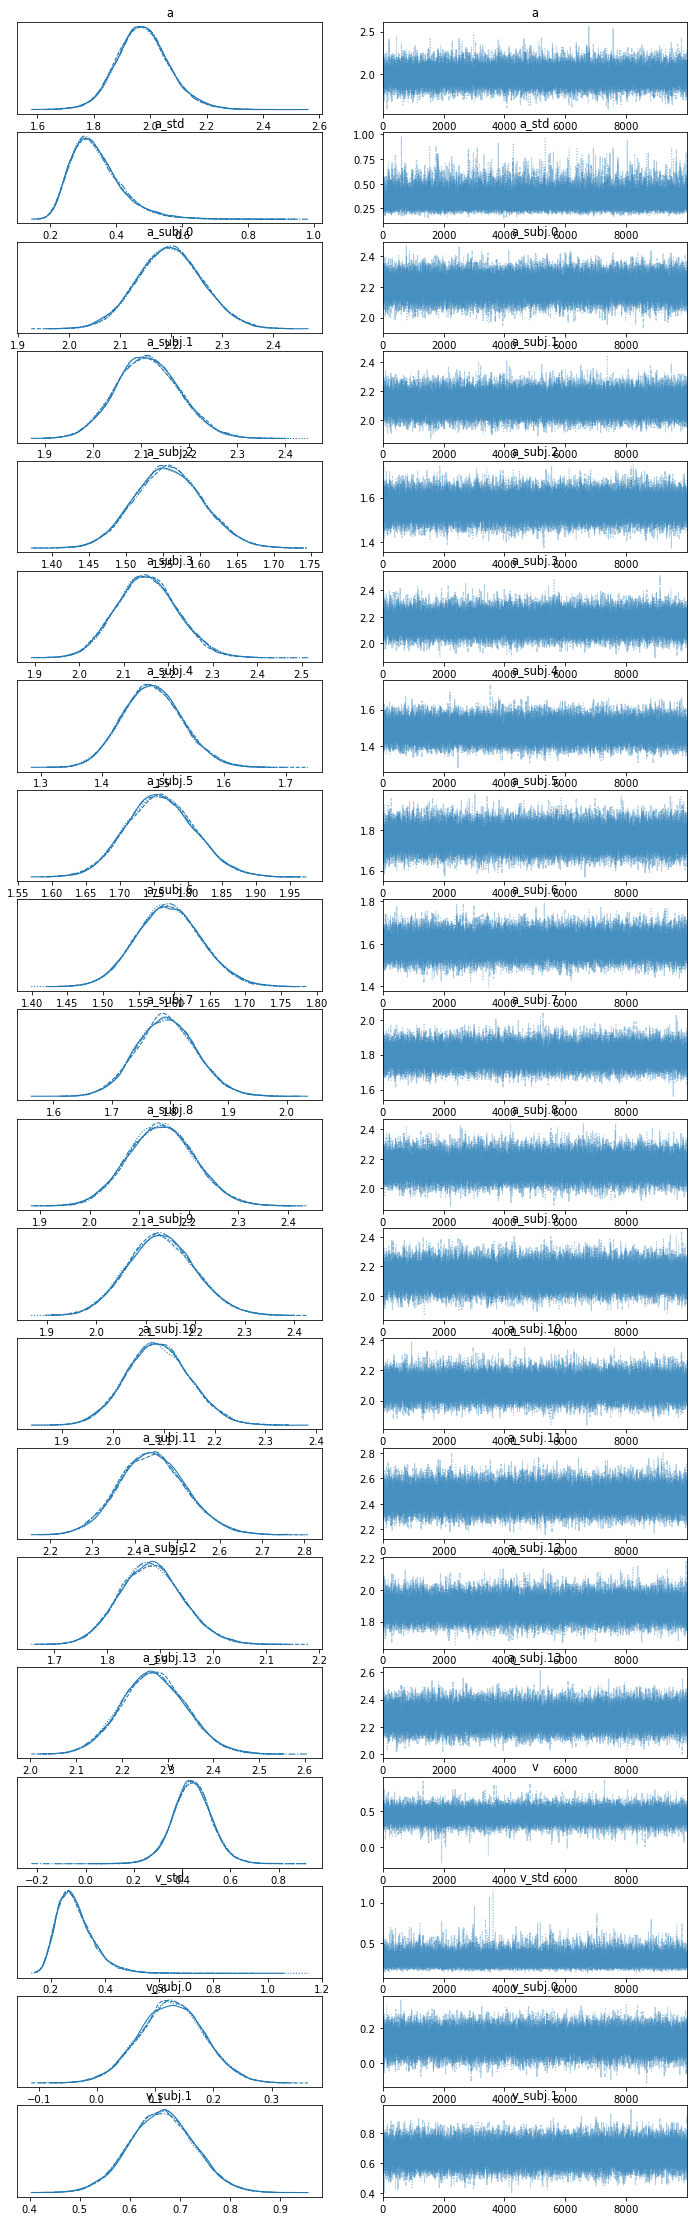

In [24]:
az.plot_trace(InfData['ms0'])

We can also only plot selected parameters' traces. Here we use regex to select var_names that start with "a" and do not contain either "subj" or "std".

array([[<AxesSubplot:title={'center':'sv'}>,
        <AxesSubplot:title={'center':'sv'}>],
       [<AxesSubplot:title={'center':'v_Intercept'}>,
        <AxesSubplot:title={'center':'v_Intercept'}>],
       [<AxesSubplot:title={'center':'v_Intercept_std'}>,
        <AxesSubplot:title={'center':'v_Intercept_std'}>],
       [<AxesSubplot:title={'center':'v_Intercept_subj.0'}>,
        <AxesSubplot:title={'center':'v_Intercept_subj.0'}>],
       [<AxesSubplot:title={'center':'v_Intercept_subj.1'}>,
        <AxesSubplot:title={'center':'v_Intercept_subj.1'}>],
       [<AxesSubplot:title={'center':'v_Intercept_subj.2'}>,
        <AxesSubplot:title={'center':'v_Intercept_subj.2'}>],
       [<AxesSubplot:title={'center':'v_Intercept_subj.3'}>,
        <AxesSubplot:title={'center':'v_Intercept_subj.3'}>],
       [<AxesSubplot:title={'center':'v_Intercept_subj.4'}>,
        <AxesSubplot:title={'center':'v_Intercept_subj.4'}>],
       [<AxesSubplot:title={'center':'v_Intercept_subj.5'}>,
       

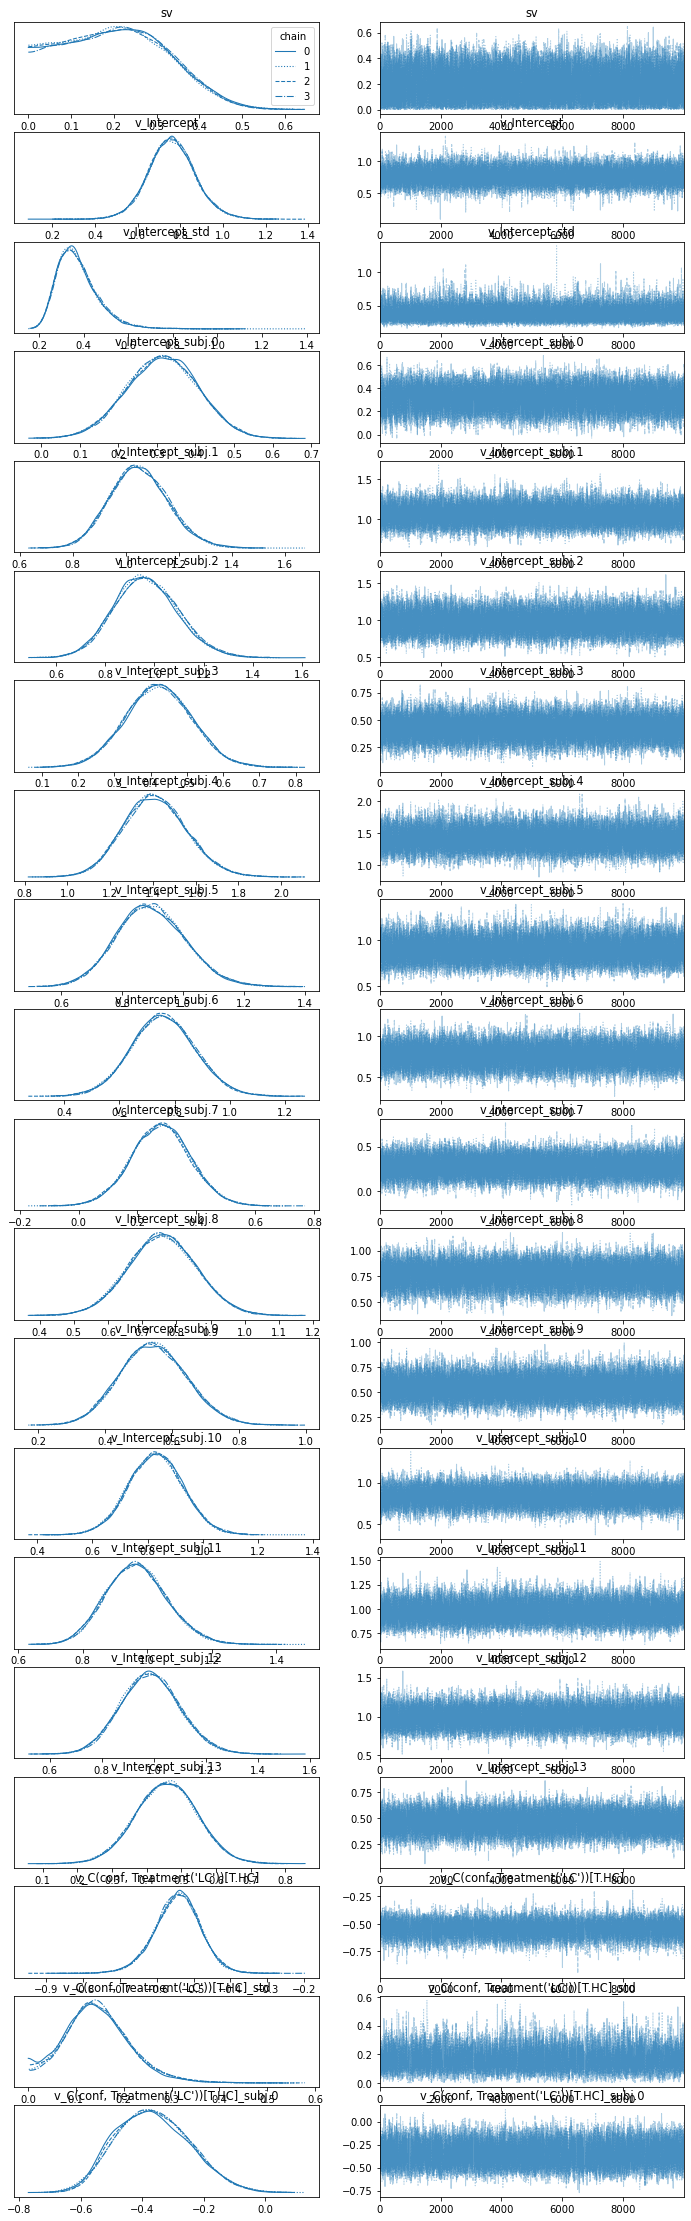

In [25]:
az.plot_trace(InfData['ms4'], var_names= ('v'), filter_vars="like", combined=False, compact=True, legend=True)

array([[<AxesSubplot:title={'center':"v_C(conf, Treatment('LC'))[T.HC]"}>,
        <AxesSubplot:title={'center':"v_C(conf, Treatment('LC'))[T.HC]"}>]],
      dtype=object)

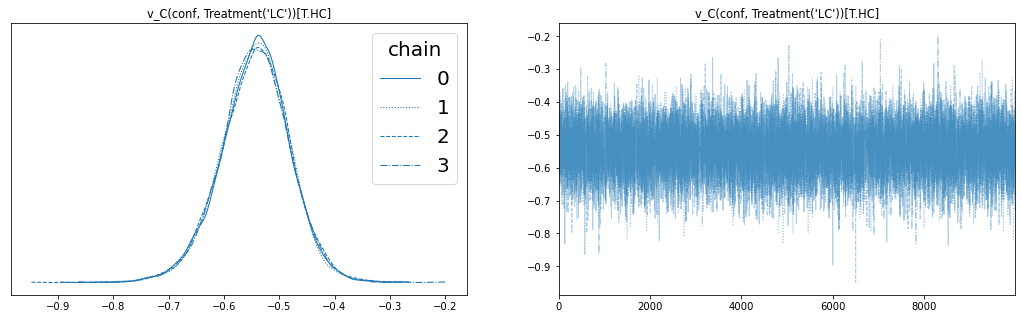

In [26]:
plt.rc('font', size=20)
az.plot_trace(InfData['ms4'], var_names=("^v(?!.*(subj|std|Intercept))"), 
              filter_vars='regex', legend=True, figsize = [18, 5])

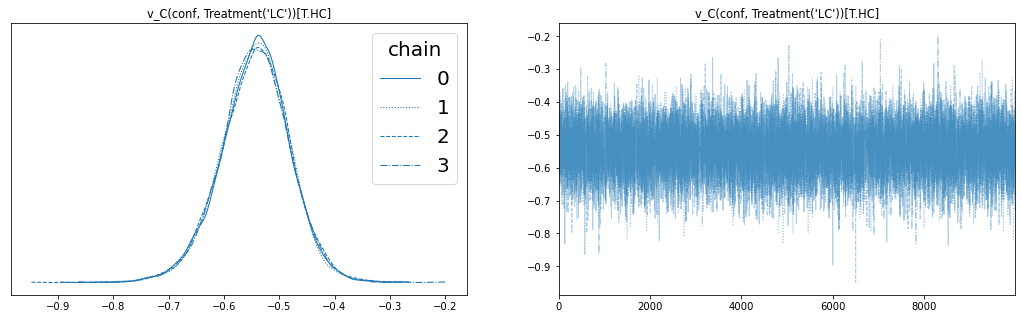

In [27]:
axes = az.plot_trace(InfData['ms4'], var_names=("^v(?!.*(subj|std|Intercept))"), filter_vars='regex', 
                     legend=True, figsize = [18, 5])
fig = axes.ravel()[0].figure
fig.savefig("fig4a.pdf")

#### Get $\hat{R}$

In [28]:
az.rhat(InfData['ms4'])

<xarray.Dataset>
Dimensions:                                   ()
Data variables: (12/83)
    a                                         float64 1.0
    a_std                                     float64 1.0
    a_subj.0                                  float64 1.0
    a_subj.1                                  float64 1.0
    a_subj.2                                  float64 1.0
    a_subj.3                                  float64 1.0
    ...                                        ...
    v_C(conf, Treatment('LC'))[T.HC]_subj.8   float64 1.0
    v_C(conf, Treatment('LC'))[T.HC]_subj.9   float64 1.0
    v_C(conf, Treatment('LC'))[T.HC]_subj.10  float64 1.0
    v_C(conf, Treatment('LC'))[T.HC]_subj.11  float64 1.001
    v_C(conf, Treatment('LC'))[T.HC]_subj.12  float64 1.0
    v_C(conf, Treatment('LC'))[T.HC]_subj.13  float64 1.0

#### Using `az.summary()` to check $\hat{R}$ and ESS

In [29]:
ms0_summary = az.summary(InfData['ms0'], kind="diagnostics", round_to=4)
ms0_summary.sort_values('r_hat')

mcse_mean  mcse_sd    ess_bulk    ess_tail   r_hat
a_subj.4      0.0003   0.0002  34842.9965  36990.5385  0.9999
a             0.0005   0.0003  39008.6197  36617.0300  1.0000
v_subj.3      0.0003   0.0002  39985.3139  38867.3424  1.0000
t_subj.12     0.0001   0.0000  37768.6075  37535.8409  1.0000
v_subj.9      0.0003   0.0002  39177.3474  37601.6839  1.0000
v_subj.11     0.0003   0.0002  39423.8781  39189.2416  1.0000
v_subj.12     0.0004   0.0003  40448.7386  39783.9094  1.0000
v_subj.13     0.0003   0.0002  39820.8182  39226.7542  1.0000
t             0.0002   0.0001  37337.4357  37059.0641  1.0000
t_std         0.0002   0.0001  36461.5608  35575.0254  1.0000
t_subj.0      0.0002   0.0001  36489.7344  36582.5482  1.0000
t_subj.4      0.0000   0.0000  34295.5445  35316.7542  1.0000
t_subj.5      0.0001   0.0000  36437.4137  38549.2009  1.0000
t_subj.6      0.0001   0.0000  37845.6994  37413.2956  1.0000
t_subj.7      0.0001   0.0000  36297.0511  37598.7156  1.0000
t_subj.9      0.0001   0.0001  38208.5860  38872.1823  1.0000
v_subj.2      0.0004   0.0003  39915.6771  38474.4008  1.0000
v_subj.1      0.0003   0.0002  39208.7154  38747.8378  1.0000
t_subj.13     0.0001   0.0001  35908.6406  38162.8831  1.0000
a_subj.11     0.0004   0.0003  35206.0540  37329.1876  1.0000
v             0.0004   0.0003  40596.4051  38618.3195  1.0000
a_subj.12     0.0003   0.0002  37310.8258  38396.0861  1.0000
a_subj.8      0.0004   0.0003  35780.9905  36933.6532  1.0000
a_subj.2      0.0002   0.0002  37447.7528  38301.2245  1.0000
a_subj.0      0.0003   0.0002  36995.0049  38122.3209  1.0000
a_subj.5      0.0003   0.0002  36349.5082  38788.1095  1.0000
a_subj.10     0.0003   0.0002  35634.4950  37324.3069  1.0000
t_subj.3      0.0002   0.0001  36468.8478  36989.6897  1.0001
a_subj.3      0.0004   0.0003  36794.4047  37692.3142  1.0001
v_std         0.0004   0.0003  37084.8168  36890.5965  1.0001
t_subj.8      0.0001   0.0001  36669.5633  37624.0245  1.0001
a_std         0.0004   0.0003  35449.1459  36798.3979  1.0001
t_subj.10     0.0001   0.0001  37815.8488  38315.4060  1.0001
t_subj.11     0.0001   0.0001  35618.1994  37179.1343  1.0001
a_subj.1      0.0003   0.0002  36727.1091  37107.5474  1.0001
t_subj.2      0.0000   0.0000  37653.6619  37690.7153  1.0001
a_subj.6      0.0002   0.0002  37498.6906  37188.0888  1.0001
v_subj.0      0.0003   0.0002  39887.3294  39353.6019  1.0001
a_subj.7      0.0003   0.0002  36671.3479  36896.2321  1.0001
a_subj.9      0.0004   0.0002  37845.6948  36582.8767  1.0001
v_subj.10     0.0003   0.0002  39780.0474  37651.4060  1.0001
v_subj.8      0.0003   0.0002  39229.3438  39068.5625  1.0001
v_subj.6      0.0004   0.0003  39873.7808  39421.4808  1.0001
v_subj.4      0.0005   0.0003  38867.8709  37899.5377  1.0001
t_subj.1      0.0001   0.0001  36056.9674  37884.8288  1.0001
v_subj.5      0.0004   0.0002  38673.6893  38339.1036  1.0001
v_subj.7      0.0003   0.0002  39019.7499  39764.5191  1.0002
a_subj.13     0.0004   0.0003  35372.6099  37264.2615  1.0002

In [30]:
ms0_summary.shape

(48, 5)

In [31]:
ms1_summary = az.summary(InfData['ms1'], kind="diagnostics", round_to=4)
ms1_summary.sort_values('r_hat')

mcse_mean  mcse_sd    ess_bulk    ess_tail   r_hat
a                   0.0006   0.0004  33070.4928  35779.4632  1.0000
v_subj.9            0.0006   0.0004  20252.1766  32147.7872  1.0000
v_subj.8            0.0006   0.0004  17959.5516  30491.3397  1.0000
v_subj.6            0.0007   0.0005  21638.3925  32256.1903  1.0000
v_std               0.0005   0.0003  31185.9962  35934.5747  1.0000
...                    ...      ...         ...         ...     ...
z_subj_trans.12     0.0008   0.0006   4568.4604   7805.7318  1.0012
z_subj_trans.2      0.0008   0.0006   4653.5446   8565.0736  1.0012
z_subj_trans.6      0.0008   0.0006   5487.3987   9732.6493  1.0013
z_subj_trans.10     0.0013   0.0009   2777.0716   3296.0743  1.0017
z_trans             0.0007   0.0005   2864.8141   4901.9123  1.0023

[67 rows x 5 columns]

In [32]:
ms2_summary = az.summary(InfData['ms2'], kind="diagnostics", round_to=4)
ms2_summary.sort_values('r_hat')

mcse_mean  mcse_sd    ess_bulk    ess_tail   r_hat
a                   0.0006   0.0004  33628.0786  35553.8742  1.0000
v_subj(LC).6        0.0009   0.0006  23008.0603  34122.9304  1.0000
v_subj(LC).1        0.0008   0.0006  22539.3008  31917.5067  1.0000
v_subj(LC).0        0.0006   0.0004  27098.3306  35802.2615  1.0000
v_subj(HC).9        0.0007   0.0005  24025.6313  36234.7607  1.0000
...                    ...      ...         ...         ...     ...
z_subj_trans.0      0.0007   0.0005   6686.5172  20718.4275  1.0005
z_std               0.0006   0.0005   1345.2994    775.5719  1.0005
z_subj_trans.5      0.0009   0.0007   4334.2392   8532.5363  1.0005
z_trans             0.0006   0.0005   3321.1910   5877.0705  1.0009
z_subj_trans.10     0.0011   0.0008   4102.6918   4328.5470  1.0012

[82 rows x 5 columns]

In [33]:
ms3_summary = az.summary(InfData['ms3'], kind="diagnostics", round_to=4)
ms3_summary.sort_values('r_hat')

mcse_mean  mcse_sd    ess_bulk    ess_tail   r_hat
a_subj.3                0.0005   0.0003  27759.7733  33963.2128  0.9999
v_Intercept_subj.8      0.0007   0.0005  16596.2386  23428.5937  1.0000
v_Intercept_subj.13     0.0005   0.0004  18426.6184  26505.3133  1.0000
a_subj.13               0.0005   0.0003  27293.8806  32933.4544  1.0000
sv                      0.0010   0.0008  13519.9868  18428.8047  1.0000
...                        ...      ...         ...         ...     ...
z_subj_trans.6          0.0008   0.0006   5367.8979   9638.4920  1.0011
z_std                   0.0007   0.0005   1548.5125   1168.2175  1.0013
z_subj_trans.2          0.0007   0.0005   6545.2570  17722.3869  1.0014
z_subj_trans.10         0.0012   0.0008   3725.1659   5675.8012  1.0017
z_trans                 0.0006   0.0004   3446.3943   7441.1360  1.0017

[68 rows x 5 columns]

In [34]:
ms4_summary = az.summary(InfData['ms4'], kind="diagnostics", round_to=4)
ms4_summary.sort_values('r_hat')

mcse_mean  mcse_sd    ess_bulk  \
a_subj.8                                 0.0004   0.0003  26039.9350   
a                                        0.0006   0.0004  33422.0348   
t_subj.13                                0.0003   0.0002  14369.5768   
v_Intercept_subj.13                      0.0007   0.0005  14889.3487   
t_subj.7                                 0.0002   0.0002  15118.3423   
...                                         ...      ...         ...   
z_subj_trans.11                          0.0007   0.0005   5027.0135   
z_trans                                  0.0007   0.0005   2449.7117   
v_C(conf, Treatment('LC'))[T.HC]_std     0.0011   0.0007   3474.0786   
z_subj_trans.5                           0.0009   0.0007   3801.6861   
z_std                                    0.0007   0.0005   1242.1137   

                                        ess_tail   r_hat  
a_subj.8                              32313.9014  0.9999  
a                                     36547.6545  1.0000  
t_subj.13                             17198.8128  1.0000  
v_Intercept_subj.13                   27493.4082  1.0000  
t_subj.7                              21623.8068  1.0000  
...                                          ...     ...  
z_subj_trans.11                       14753.2143  1.0013  
z_trans                                3336.0763  1.0015  
v_C(conf, Treatment('LC'))[T.HC]_std   1789.4902  1.0016  
z_subj_trans.5                         4308.1723  1.0021  
z_std                                   943.0046  1.0030  

[83 rows x 5 columns]

In [35]:
paramList = list(ms4_summary.index.values.tolist()) # check the free parameters of ms4
paramList

['a',
 'a_std',
 'a_subj.0',
 'a_subj.1',
 'a_subj.2',
 'a_subj.3',
 'a_subj.4',
 'a_subj.5',
 'a_subj.6',
 'a_subj.7',
 'a_subj.8',
 'a_subj.9',
 'a_subj.10',
 'a_subj.11',
 'a_subj.12',
 'a_subj.13',
 't',
 't_std',
 't_subj.0',
 't_subj.1',
 't_subj.2',
 't_subj.3',
 't_subj.4',
 't_subj.5',
 't_subj.6',
 't_subj.7',
 't_subj.8',
 't_subj.9',
 't_subj.10',
 't_subj.11',
 't_subj.12',
 't_subj.13',
 'sv',
 'sz',
 'st',
 'z_trans',
 'z_std',
 'z_subj_trans.0',
 'z_subj_trans.1',
 'z_subj_trans.2',
 'z_subj_trans.3',
 'z_subj_trans.4',
 'z_subj_trans.5',
 'z_subj_trans.6',
 'z_subj_trans.7',
 'z_subj_trans.8',
 'z_subj_trans.9',
 'z_subj_trans.10',
 'z_subj_trans.11',
 'z_subj_trans.12',
 'z_subj_trans.13',
 'v_Intercept',
 'v_Intercept_std',
 'v_Intercept_subj.0',
 'v_Intercept_subj.1',
 'v_Intercept_subj.2',
 'v_Intercept_subj.3',
 'v_Intercept_subj.4',
 'v_Intercept_subj.5',
 'v_Intercept_subj.6',
 'v_Intercept_subj.7',
 'v_Intercept_subj.8',
 'v_Intercept_subj.9',
 'v_Intercept_sub

In [36]:
len(paramList)

83

### Model comparison and selection

#### DIC

Here we record the DIC of each model in the models and sort by DIC.

In [37]:
%%time

tmp_dic = []
indx_name = []
for m_key, model in models.items():
    m_tmp = kabuki.utils.concat_models(model)
    tmp_dic.append(m_tmp.dic)
    indx_name.append(m_key)
    
comp_dic = pd.DataFrame(tmp_dic, index=indx_name, columns=['dic'])
comp_dic = comp_dic.sort_values(by=['dic'])
comp_dic = comp_dic.reset_index()
comp_dic.rename(columns={'index':'rank'}, inplace=True)
comp_dic

CPU times: user 43.2 s, sys: 522 ms, total: 43.8 s
Wall time: 43.8 s


rank           dic
0  ms2  10654.827456
1  ms4  10656.368613
2  ms3  10661.306425
3  ms1  10835.371664
4  ms0  10973.378281

#### PSIS-LOO-CV

Warining here is caused by large number as input of `exp()`, solution is [here](https://stackoverflow.com/questions/40726490/overflow-error-in-pythons-numpy-exp-function).

In [38]:
comp_loo = az.compare(InfData, ic='loo', scale="deviance")
comp_loo

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1080: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1080: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1080: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(

rank           loo        p_loo         d_loo        weight           se  \
ms4     0  16989.845983  3090.371443      0.000000  3.891242e-01  2684.316972   
ms3     1  17092.294429  3131.972847    102.448445  1.283791e-01  2651.010887   
ms2     2  17558.232174  3380.092525    568.386190  2.889683e-01  2846.888490   
ms1     3  17821.830305  3410.453022    831.984322  2.371228e-12  2805.408035   
ms0     4  29258.028358  9112.555312  12268.182375  1.935283e-01  4500.111226   

             dse  warning loo_scale  
ms4     0.000000     True  deviance  
ms3   164.096298     True  deviance  
ms2   334.517479     True  deviance  
ms1   311.456248     True  deviance  
ms0  4965.890252     True  deviance

####  WAIC

In [39]:
comp_waic = az.compare(InfData, ic='waic', scale="deviance")
comp_waic

rank          waic        p_waic        d_waic    weight            se  \
ms3     0  23698.038738   6434.845002      0.000000  0.000000   6828.107498   
ms4     1  24450.049571   6820.473236    752.010833  0.592812   7313.751016   
ms2     2  25051.495310   7126.724093   1353.456572  0.204882   7281.221385   
ms1     3  25470.677727   7234.876733   1772.638989  0.000000   7256.164389   
ms0     4  77959.448495  33463.265380  54261.409757  0.202306  24418.323919   

              dse  warning waic_scale  
ms3      0.000000     True   deviance  
ms4    534.825258     True   deviance  
ms2    704.296319     True   deviance  
ms1    763.623469     True   deviance  
ms0  25233.449382     True   deviance

#### PSIS issues
**Warnings**: Now that we found $\hat{k} >  0.7$, which means importance sampling (PSIS) is not able to provide useful estimate for that component/observation. Highly influential observations have high $\hat{k}$ values. Very high $\hat{k}$ values often indicate model misspecification, outliers or mistakes in data processing.

Also, `p_loo`is large than *p*, which is number of parameters of the model. Large `p_loo` means the model is badly misspecified according to Aki Vehtari's [Q & A](https://avehtari.github.io/modelselection/CV-FAQ.html#18_What_is_the_interpretation_of_p_loo). For all models, the *N*, number of obersvations, is 3988, and the number of parameters varies from 48 to 83. Thus, `p_loo` is much larger than numbers of parameters for all models.

As we can from below, this was primarily because of a few outliers. As HDDM allow for 5 percent of outliers in modelling, it is not surprising that these outliers stronly influenced the model performance. Here, we remove the outliers from all models and check the results again.

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1080: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1080: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa


<AxesSubplot:title={'center':'ms3 - ms4'}, ylabel='ELPD difference'>

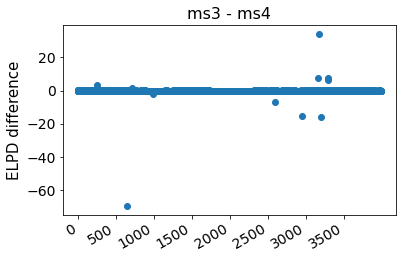

In [40]:
az.plot_elpd({"ms3": InfData['ms3'], "ms4": InfData['ms4']}, xlabels=True)

Below we visulaize the `k_hat` of each data point.

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1080: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa


<AxesSubplot:xlabel='Data Point', ylabel='Shape parameter k'>

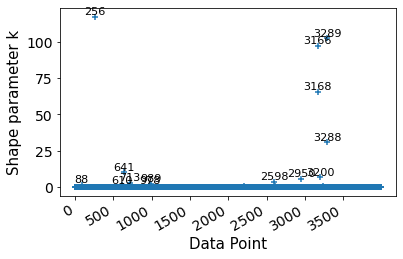

In [41]:
khats = az.loo(InfData['ms4'], pointwise=True).pareto_k

az.plot_khat(khats, xlabels=True, threshold=0.7)

Here we used a very simple soluation: removing the outliers and re-calculate the `loo` and `waic`.

In [42]:
loo_ms0 = az.loo(InfData['ms0'], pointwise=True)
loo_ms1 = az.loo(InfData['ms1'], pointwise=True)
loo_ms2 = az.loo(InfData['ms2'], pointwise=True)
loo_ms3 = az.loo(InfData['ms3'], pointwise=True)
loo_ms4 = az.loo(InfData['ms4'], pointwise=True)

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1080: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1080: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1080: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(

In [43]:
outliers0 = loo_ms0.pareto_k.where(loo_ms0.pareto_k >= 0.7, drop= True).trial_idx.values
outliers1 = loo_ms1.pareto_k.where(loo_ms1.pareto_k >= 0.7, drop= True).trial_idx.values
outliers2 = loo_ms2.pareto_k.where(loo_ms2.pareto_k >= 0.7, drop= True).trial_idx.values
outliers3 = loo_ms3.pareto_k.where(loo_ms3.pareto_k >= 0.7, drop= True).trial_idx.values
outliers4 = loo_ms4.pareto_k.where(loo_ms4.pareto_k >= 0.7, drop= True).trial_idx.values

# create a index array to remove outliers
outliers = np.unique(np.concatenate((outliers0, outliers1, outliers2, outliers3, outliers4), axis=0))
new_indx = data_cavanagh.index.values[~np.isin(data_cavanagh.index.values, outliers)]

In [44]:
InfData2 = {}
InfData2['ms0'] = InfData["ms0"].isel(trial_idx=new_indx)
InfData2['ms1'] = InfData["ms1"].isel(trial_idx=new_indx)
InfData2['ms2'] = InfData["ms2"].isel(trial_idx=new_indx)
InfData2['ms3'] = InfData["ms3"].isel(trial_idx=new_indx)
InfData2['ms4'] = InfData["ms4"].isel(trial_idx=new_indx)

In [45]:
16384*4

65536

In [46]:
comp_loo2 = az.compare(InfData2, ic='loo', scale="deviance")
comp_loo2

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


rank           loo      p_loo       d_loo        weight          se  \
ms4     0  10646.246430  50.725559    0.000000  9.147305e-13  123.509673   
ms2     1  10647.206470  55.943728    0.960040  5.660574e-01  123.340999   
ms3     2  10650.379132  43.231669    4.132702  2.282562e-01  123.394241   
ms1     3  10824.930559  41.744451  178.684130  4.426213e-12  120.527026   
ms0     4  10884.000088  36.239047  237.753658  2.056864e-01  117.516809   

           dse  warning loo_scale  
ms4   0.000000    False  deviance  
ms2   5.882238    False  deviance  
ms3   4.851643    False  deviance  
ms1  28.139917    False  deviance  
ms0  40.422374    False  deviance

In [47]:
comp_waic2 = az.compare(InfData2, ic='waic', scale="deviance")
comp_waic2

rank          waic     p_waic      d_waic    weight          se  \
ms4     0  10646.198225  50.701457    0.000000  0.000000  123.508432   
ms2     1  10647.152619  55.916803    0.954393  0.566269  123.339607   
ms3     2  10650.339862  43.212034    4.141637  0.227521  123.393387   
ms1     3  10824.891214  41.724779  178.692989  0.000000  120.526164   
ms0     4  10883.438891  35.958449  237.240665  0.206210  117.506792   

           dse  warning waic_scale  
ms4   0.000000    False   deviance  
ms2   5.882308    False   deviance  
ms3   4.851192    False   deviance  
ms1  28.139530    False   deviance  
ms0  40.416072     True   deviance

warning: using `az.loo_pit` requires same shape for  y_hat and log_weights, which is not the case if the PPC samples is not the same as the sample of MCMC.

In [48]:
# az.loo_pit(idata=InfData['ms0'], y="rt") 

#### Posterior predictive check

<AxesSubplot:xlabel='rt / rt'>

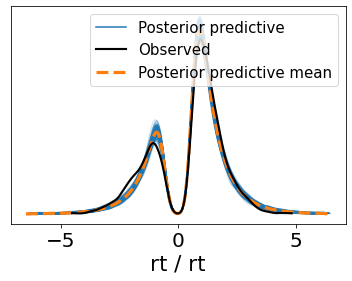

In [49]:
az.plot_ppc(InfData['ms0'], var_names=['rt'], textsize=20, 
            num_pp_samples=300, alpha = 0.2)

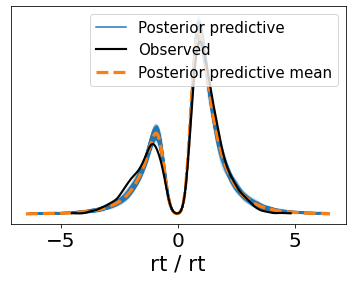

In [50]:
axes = az.plot_ppc(InfData['ms0'], var_names=['rt'], num_pp_samples=300, textsize=20, alpha = 0.2)
# fig = axes.get_figure()
axes.figure.savefig("fig5a.pdf")

<AxesSubplot:xlabel='rt / rt'>

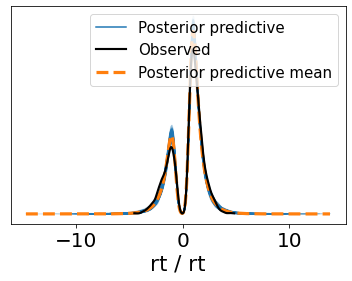

In [51]:
az.plot_ppc(InfData['ms4'], var_names=['rt'], textsize=20, 
            num_pp_samples=300, alpha = 0.2)

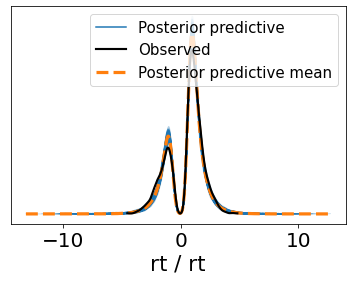

In [52]:
axes = az.plot_ppc(InfData['ms4'], var_names=['rt'], num_pp_samples=300, textsize=20, alpha = 0.2)
axes.figure.savefig("fig5b.pdf")

[3, 'HC']
[3, 'LC']


array([[<AxesSubplot:xlabel='rt / rt\nsubj_3, conf_HC'>,
        <AxesSubplot:xlabel='rt / rt\nsubj_3, conf_LC'>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

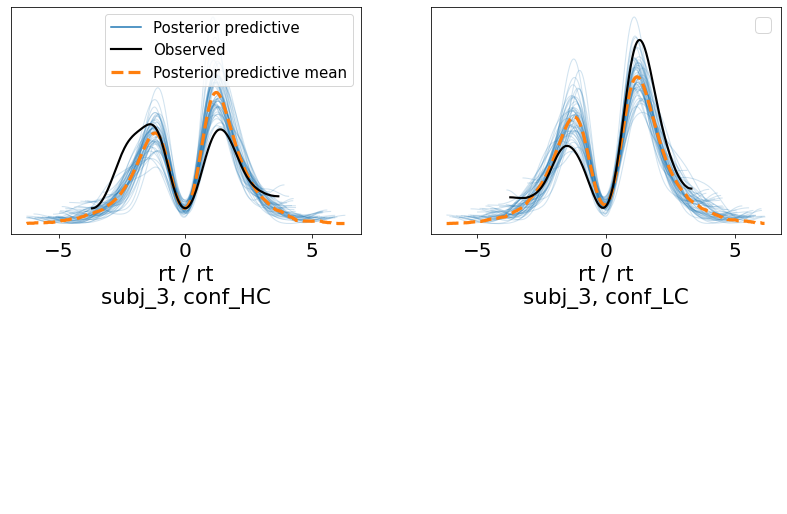

In [53]:
plot_ppc_by_cond(data = InfData['ms0'], or_d = data_cavanagh, subjs = [3], conds = ['conf'], 
                 num_pp_samples=300, random_seed = 7, alpha = 0.2, grid = [2,2], 
                 textsize=20, var_names=['rt'])

[3, 'HC']
[3, 'LC']


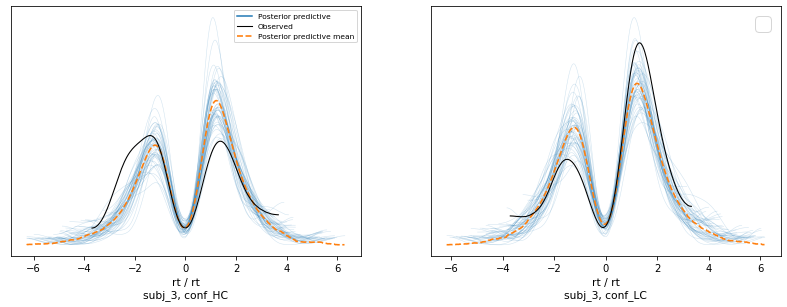

In [54]:
axes = plot_ppc_by_cond(data = InfData['ms0'], or_d = data_cavanagh, subjs = [3], 
                 conds = ['conf'], num_pp_samples=300, # colors = ['r', 'k', 'b'], 
                 random_seed = 7, alpha = 0.2, grid = [1,2], textsize=10, var_names=['rt'])
axes.ravel()[0].figure.savefig("fig5c.pdf")

[3, 'HC']
[3, 'LC']


array([[<AxesSubplot:xlabel='rt / rt\nsubj_3, conf_HC'>,
        <AxesSubplot:xlabel='rt / rt\nsubj_3, conf_LC'>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

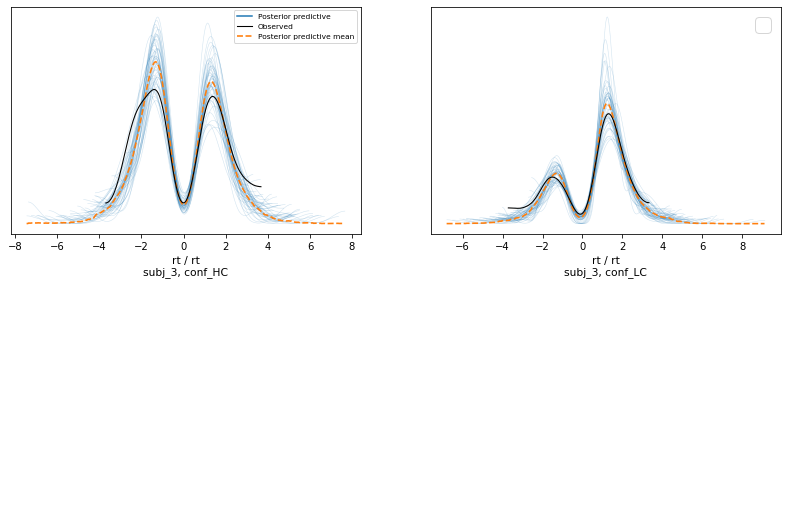

In [55]:
plot_ppc_by_cond(data = InfData['ms4'], or_d = data_cavanagh, subjs = [3], conds = ['conf'],
                 num_pp_samples=300, random_seed = 7,alpha = 0.2, grid = [2,2], 
                 textsize=10, var_names=['rt'])

[3, 'HC']
[3, 'LC']


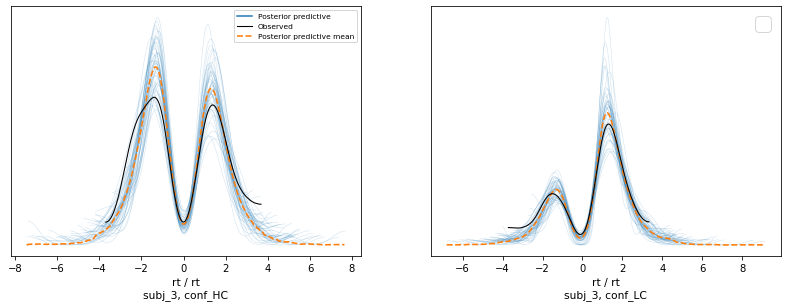

In [56]:
axes = plot_ppc_by_cond(data = InfData['ms4'], or_d = data_cavanagh, subjs = [3], conds = ['conf'],
                 num_pp_samples=300, random_seed = 7, # colors = ['r', 'k', 'b'], 
                 alpha = 0.2, grid = [1,2], textsize=10, var_names=['rt'])
axes.ravel()[0].figure.savefig("fig5d.pdf")

## Statistical Inference

Here we onlyu examplified how to us ROPE + HDI method. Assume that we are interested in the effect of conflit level on drift rate `v` and we used [-0.2, 0.2] as the ROPE. Then we can used visualize the ROPE and HDI with `az.plot_posterior()`.

<AxesSubplot:title={'center':"v_C(conf, Treatment('LC'))[T.HC]"}>

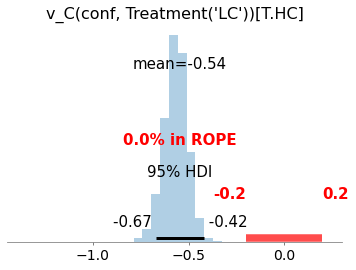

In [57]:
az.plot_posterior(InfData['ms4'], filter_vars='regex', 
                  var_names=("^v_(?!.*(subj|std|Intercept))"), 
                  kind='hist', hdi_prob=0.95, 
                  rope=[-0.2, 0.2], rope_color='r')

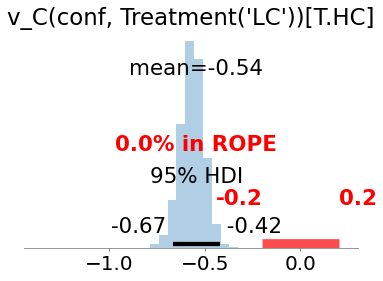

In [58]:
# using regex to select var_names that start with "a_theta" and do not contain either "subj" or "std"
axes = az.plot_posterior(InfData['ms4'],var_names=("^v_(?!.*(subj|std|Intercept))"),filter_vars='regex',
                         # grid = [2, 2], 
                         kind = 'hist',
                         hdi_prob = 0.95,
                         rope = [-0.2, 0.2], # assume this is our ROPE
                         textsize=20, 
                         rope_color = 'r')
# fig = axes.ravel()[0].figure
axes.figure.savefig("fig6.pdf")